# Simple Neural network in PyTorch

Let's look at simple data of student test results.
The data includes Hours studied, and hours of sleep

In [1]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 13]

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


## Introduction: What is a Tensor?

A vector is an 1D array of values, like:

In [2]:
[1.0, 2.0, 3.0]

[1.0, 2.0, 3.0]

A matrix is a 2D array of values, like:

In [3]:
[[1.0, 2.0, 3.0],
 [2.0, 4.0, 6.0],
 [3.0, 8.0, 9.0]]

[[1.0, 2.0, 3.0], [2.0, 4.0, 6.0], [3.0, 8.0, 9.0]]

A tensor is simply a generalization to n-dimensions:

it is a n-dimension array of values

In [4]:
data = np.array([[2, 9, 92], # hours studied, hours of sleep, test result
                 [1, 5, 100],
                 [3, 6, 89]
                ])

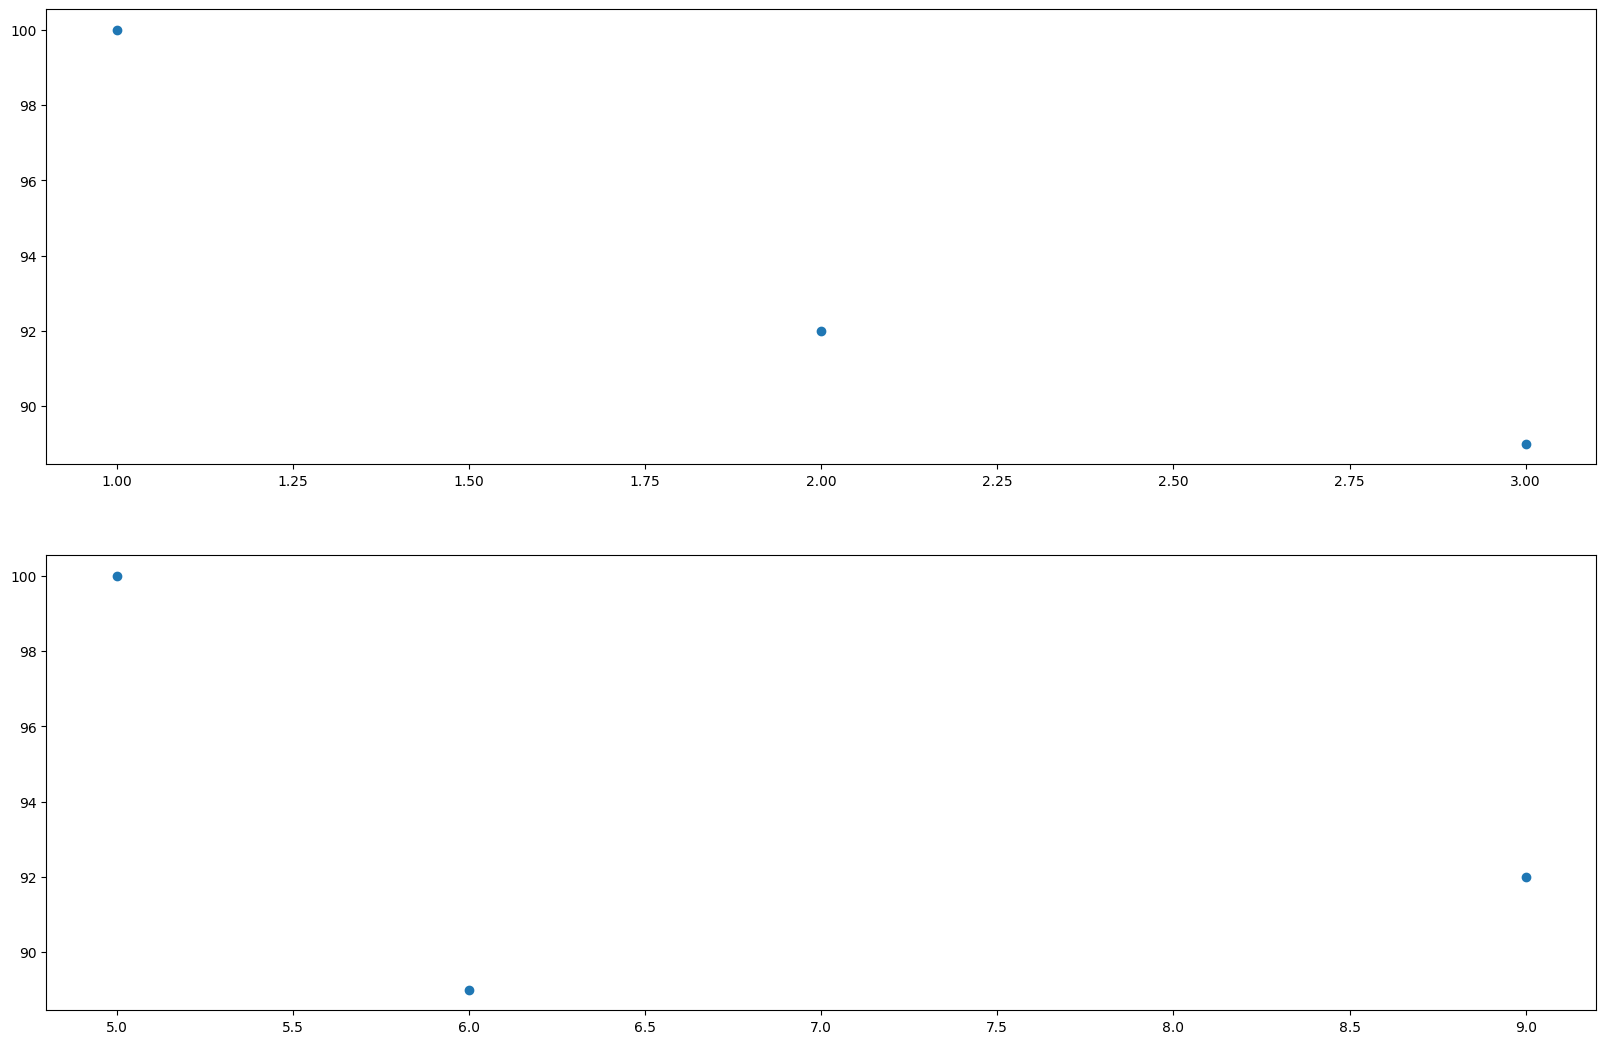

In [5]:
fig, (ax0, ax1) = plt.subplots(2,1)
ax0.scatter(x=data[:,0], y=data[:,2])
ax1.scatter(x=data[:,1], y=data[:,2])

In [6]:
# input data -> [hours studied, hours of sleep]
X = torch.tensor(data[..., :2], dtype=torch.float) # 3 X 2 tensor

# output data -> [test result]
y = torch.tensor(data[..., 2:3], dtype=torch.float) # 3 X 1 tensor
# note we need to specify a range to create a matrix of 3 x 1 as opposed to a single vector, as input to the tensor

In [7]:
X

tensor([[2., 9.],
        [1., 5.],
        [3., 6.]])

In [8]:
y

tensor([[ 92.],
        [100.],
        [ 89.]])

In [9]:
print(X.size())
print(y.size())

torch.Size([3, 2])
torch.Size([3, 1])


## Scaling data
Ideally we want to deal with numbers in the range [0, 1], so all the tensors are scaled to this range.

In [10]:
# typically, we would scale by normalizing the data with something like:
# X = (X - X.min()) / (X.max() - X.min())
# by we know that the min may go to 0
Xmax = X.max()
Xstd = X.std()
Xmean = X.mean()
X = (X - Xmean) / (2.0 * Xstd)

In [11]:
X

tensor([[-0.3963,  0.7926],
        [-0.5661,  0.1132],
        [-0.2265,  0.2831]])

In [12]:
# while y is already between 0 amd 100, so we just need to devide by 100
y = y / 100.0

In [13]:
y

tensor([[0.9200],
        [1.0000],
        [0.8900]])

## Neural Network structure

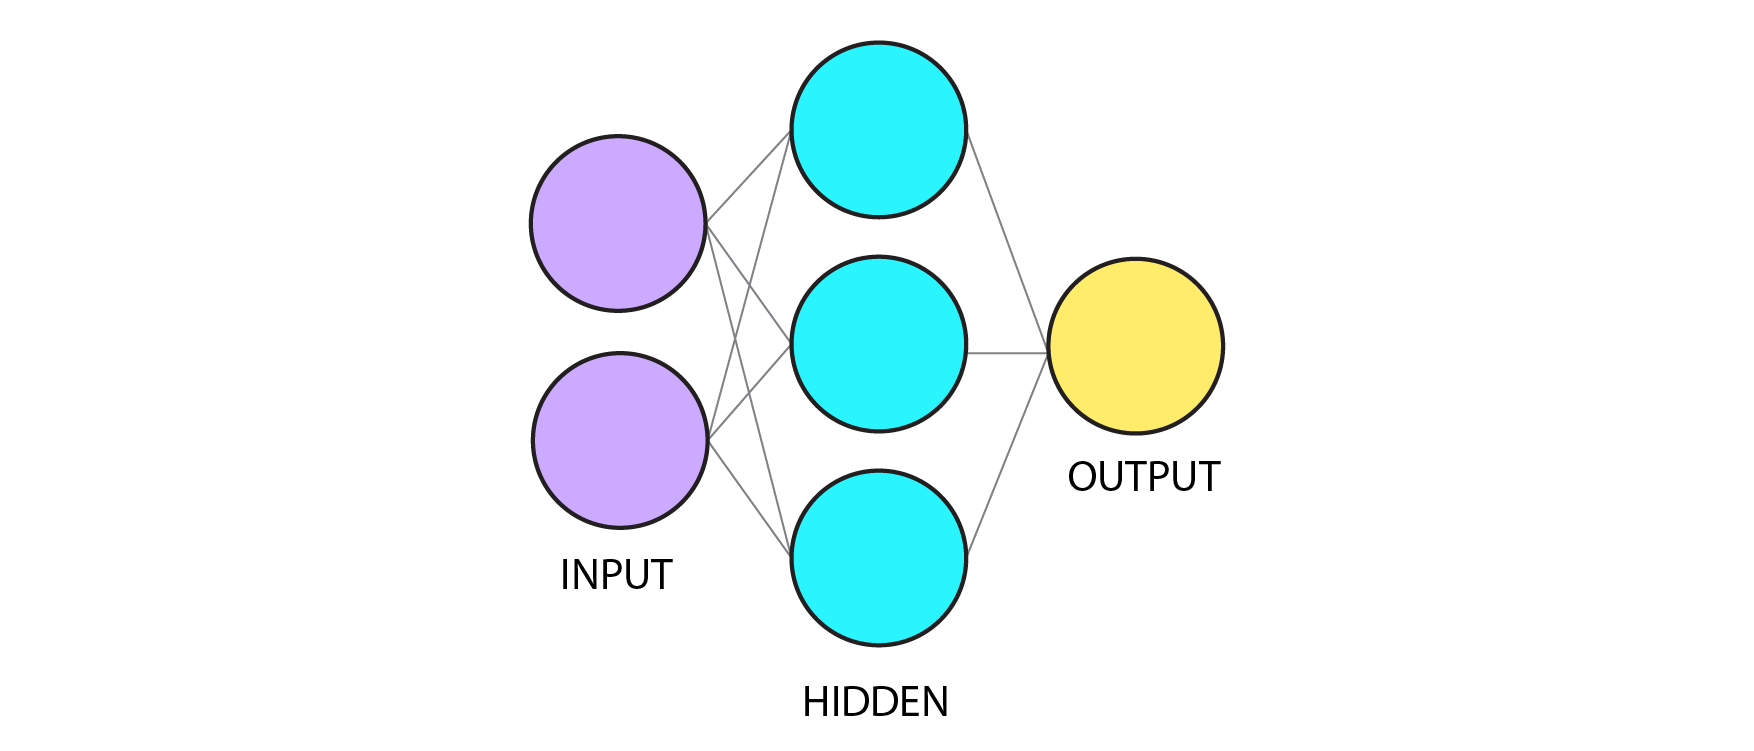

## Note:
- the input is the input tensor (size 2 x 1)
- the hidden layer is a convolution of the input with a **weight** tensor **W1**, here of size (3 x 1) but it could be more, 
- the hidden layer is then convoluted again with another **weight** tensor **W2**
- the output is the result that needs to be predicted (size 1 x 1)


## Activation function
- In the code below, the output of the convolutions between input and hidden layer is transformed 
using a non-linear function, ReLU for Rectifier Linear Unit
- The output of the hidden layer is convoluted with weight W2 and also transformed with the ReLu function.

The **activation function** introduces non-linearity in the model, which is what allows for building many-layer networks. 

If the transform between input and hidden layer was a linear transformation (like the weight convolution), compositing those transformations could be always ultimately be reduced to a single combined linear transformation, defeating the purpose of multiple layers.

The introduction of non-linearity in the model insures that each layer learns it's own set of parameters independently.

## Hidden layer(s) and weights tensors
Looking at the visual representation of neural networks can be confusing: hidden layers are tensors, 
they represent input data that has been transformed more and more as the layer is deeper and deeper into the network.

This is not to be confused with the weights tensors: the weight tensors don't usually show on the network *computational graph* as *layers*: they are represented by the lines between layers. Even though they barely show, these are the tensors that ultimately matter: the final *model* consists of these weights that were optimized by training on a large set of data.

In [14]:
class Neural_Network(nn.Module):
    def __init__(self, ):
        super(Neural_Network, self).__init__()
        # network parameters (the dimensional parameters of the network)
        self.inputSize  = 2
        self.outputSize = 1
        self.hiddenSize = 3
        
        self.learning_rate = 1e-3
        
        # weights tensors: this is what is actually being trained and optimized.
        # W1 transforms input into the 1st hidden layer (and Rectification or 'Activation' is applied)
        self.W1 = torch.randn(self.inputSize, self.hiddenSize, requires_grad=True) # 3 X 2 tensor
        # W2 tranforms hidden layer into the output (through Activation)
        self.W2 = torch.randn(self.hiddenSize, self.outputSize, requires_grad=True) # 3 X 1 tensor
        
    # forward is how the network layers are constructed from Weights tensors, going from input to output
    def forward(self, X):
        self.h = X.mm(self.W1)
        self.h_relu = self.h.clamp(min=0)
        y_pred = self.h_relu.mm(self.W2)
        return y_pred
        
    # the Activation function
    def relu(self, x):
        return x.clamp(min=0)
    
    # backwards is where the optimization happens: 
    # Weights tensor performance is evaluated based on the error 
    # between computed output (from input, through the network) and known output (the labels).
    # Weight tensors are adjusted to regress towards minimizing the error.
    def backward(self, X, y, y_pred):
        # error = actual/known output y - computed output o
#         grad_y_pred = 2.0 * (y_pred - y)
#         grad_W2 = self.h_relu.t().mm(grad_y_pred)
#         grad_h_relu = grad_y_pred.mm(self.W2.t())
#         grad_h = grad_h_relu.clone()
#         grad_h[self.h < 0] = 0
#         grad_W1 = X.t().mm(grad_h)
#         self.W1 -= self.learning_rate * grad_W1
#         self.W2 -= self.learning_rate * grad_W2

        loss = (y_pred - y).pow(2).sum()
        loss.backward()
        with torch.no_grad():
            self.W1 -= self.learning_rate * self.W1.grad
            self.W2 -= self.learning_rate * self.W2.grad
            # Manually zero the gradients after running the backward pass
            self.W1.grad.zero_()
            self.W2.grad.zero_()
        
        
    def train(self, X, y):
        # forward + backward pass for training
        y_pred = self.forward(X)
        loss = (y_pred - y).pow(2).sum()
#         self.backward(X, y, y_pred)
        loss.backward()
        with torch.no_grad():
            self.W1 -= self.learning_rate * self.W1.grad
            self.W2 -= self.learning_rate * self.W2.grad
            # Manually zero the gradients after running the backward pass
            self.W1.grad.zero_()
            self.W2.grad.zero_()        
        return loss.item()
        
    def predict(self, x):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): " + str(x))
        print ("Output: " + str(self.forward(x)))

## However, this is only to explain how it works under the hood.
### In reality, this model is not very good. It doesn't include bias, and doesn't converge well at all.

### Anyway, in PyTorch, building a model is actually much simpler, thanks to many built in functionalities 

It comes down to:

In [15]:
model = nn.Sequential(
            nn.Linear(2,3),
            nn.ReLU(),
            nn.Linear(3,1)
        )

loss_fn = nn.MSELoss(reduction='sum')

learning_rate = 1e-3

## Training is usually done outside the model itself, since the tensors backward functions are available

In [16]:
# 'naive' training method
def train(X, y):
    y_pred = model(X)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y)

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for p in model.parameters():
            p.data -= learning_rate * p.grad
    return loss.item()

In [17]:
# training using an optimizer

import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_optim(X, y):

    optimizer.zero_grad()    
    y_pred = model(X)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y)

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    optimizer.step()
    return loss.item() 

## Training the network

Training consists in running the **forward** pass and then the **backward** pass several times, 
until the fit is acceptable.

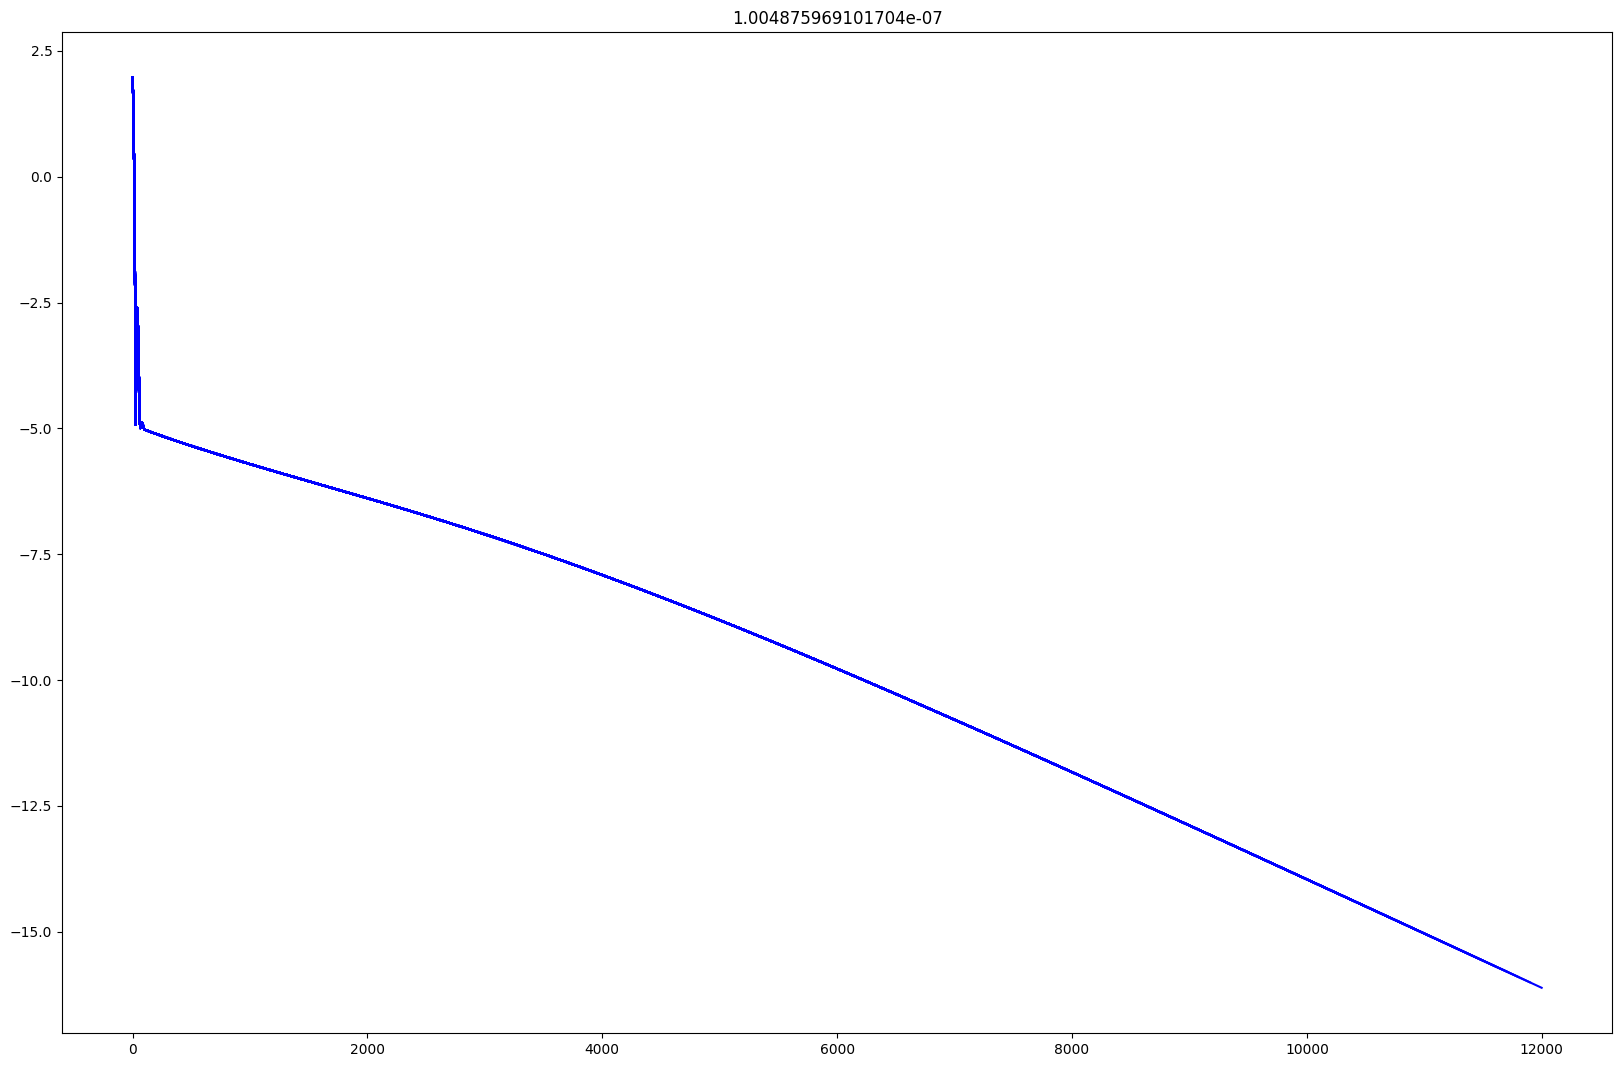

In [18]:
from IPython import display

fig = plt.figure(1)
ax = fig.add_subplot(111)
fig.show()

step = 0
losses = []
threshold = 1e-7

loss = train_optim(X, y)
while loss > threshold:
    if step % 100 == 0:
        display.display(plt.gcf())
        display.clear_output(wait=True)
        ax.plot(losses, 'b-')
        ax.set_title(loss)
    loss = train_optim(X, y)
    losses.append(np.log(loss))
    step += 1

In [19]:
xPredicted = torch.tensor([[2.0, 9.0]])
xPredicted = (xPredicted - Xmean) / (2.0 * Xstd) # xPredicted.max()
# NN.predict(xPredicted)
model(xPredicted)

tensor([[0.9199]], grad_fn=<AddmmBackward0>)

In [20]:
xPredicted = torch.tensor([[1.0, 5.0]])
xPredicted = (xPredicted - Xmean) / (2.0 * Xstd) #xPredicted.max()
# NN.predict(xPredicted)
model(xPredicted)

tensor([[0.9999]], grad_fn=<AddmmBackward0>)

In [21]:
xPredicted = torch.tensor([[3.0, 6.0]])
xPredicted = (xPredicted - Xmean) / (2.0 * Xstd) #xPredicted.max()
# NN.predict(xPredicted)
model(xPredicted)

tensor([[0.8903]], grad_fn=<AddmmBackward0>)

In [22]:
xPredicted = torch.tensor([[4.0, 1.0]])
xPredicted = (xPredicted - Xmean) / (2.0 * Xstd) #xPredicted.max()
# NN.predict(xPredicted)
model(xPredicted)

tensor([[0.8717]], grad_fn=<AddmmBackward0>)